In [53]:
%pip install PyGithub python-dotenv pandas tqdm cachetools scikit-learn nbformat numpy tqdm matplotlib dtreeviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [54]:
from github import Github
import pandas as pd
from dotenv import load_dotenv
from os import getenv, path, remove
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

In [55]:
load_dotenv(override=True)
g = Github(getenv('GITHUB_TOKEN'), per_page=100)

In [56]:
def get_commit_messages(commits: pd.DataFrame, repo_obj) -> pd.DataFrame:
    messages = [repo_obj.get_commit(commit).commit.message for commit in commits['id']]
        
    return pd.DataFrame(messages, columns=['message'])

In [57]:
def get_pull_reqs_related_to_commits(commits: pd.DataFrame, repo_obj) -> pd.DataFrame:
    pull_reqs = repo_obj.get_pulls(state='all')
    
    data = []
    
    for commit in commits['id']:
        for pull_req in pull_reqs:
            if pull_req.merge_commit_sha == commit:
                data.append({
                    'pull_req_id': pull_req.number,
                    'pull_req_title': pull_req.title,
                    'pull_req_body': pull_req.body
                })

    return pd.DataFrame(data, columns=['pull_req_id', 'pull_req_title', 'pull_req_body'])

In [58]:
def get_directories(commits: pd.DataFrame, repo_obj) -> pd.DataFrame:
    
    def extract_directories(commit_id):
        directories = set()
        for file in repo_obj.get_commit(commit_id).files:
            file_path = file.filename
            directory = '/'.join(file_path.split('/')[:-1]) if '/' in file_path else '.'
            directories.add(directory)
        return ' '.join(directories)
    
    commit_dirs = [extract_directories(commit) for commit in commits['id']]
    
    return pd.DataFrame(commit_dirs, columns=['dirs'])

In [59]:
repos = [('spring-guides', 'gs-accessing-data-jpa'), ('Azure-Samples', 'java-native-telemetry'),
        ('aws-samples', 'amazon-ivs-player-web-sample'), 
        ('aws-samples', 'aws-marketplace-serverless-saas-integration')]

repo_infos = {}

def process_repo_commits(org: str, repo: str):
    repo_data = pd.read_csv(path.join('repos', f'{repo}.csv'))
    repo_obj = g.get_organization(org).get_repo(repo)
    
    messages_df = get_commit_messages(repo_data, repo_obj)
    directories_df = get_directories(repo_data, repo_obj)
    pull_reqs_df = get_pull_reqs_related_to_commits(repo_data, repo_obj)
    
    combined_df = pd.concat([repo_data['id'], repo_data['ecosystem'], repo_data['repo'],
                             messages_df, directories_df, pull_reqs_df, repo_data['opinion']], axis=1)

    return combined_df
    
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_repo_commits, repo[0], repo[1]) for repo in repos]
    
    for future in tqdm(as_completed(futures), desc="Processing repos", unit='repo', total=len(repos), ncols=100, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}] {percentage:3.0f}%'):
        repo_info = future.result()
        if repo_info['ecosystem'].iloc[0] not in repo_infos:
            repo_infos[repo_info['ecosystem'].iloc[0]] = repo_info
        else:
            repo_infos[repo_info['ecosystem'].iloc[0]] = pd.concat([repo_infos[repo_info['ecosystem'].iloc[0]], repo_info])

Processing repos:   0%|                                                | 0/4 [00:00<?, ?repo/s]   0%

Processing repos: 100%|████████████████████████████████████████| 4/4 [00:42<00:00, 10.57s/repo] 100%


In [60]:
def naive_bayes_train_by_ecosystem(ecosystem_info: pd.DataFrame):
    class_counts = ecosystem_info['opinion'].value_counts()
    filtered_classes = class_counts[class_counts >= 2].index
    filtered_commits = ecosystem_info[ecosystem_info['opinion'].isin(filtered_classes)]

    vectorizer = TfidfVectorizer()

    X_message = vectorizer.fit_transform(filtered_commits['message'])
    y = filtered_commits['opinion']

    combined_categorical_features = filtered_commits[['pull_req_title', 'pull_req_body', 'dirs']].fillna('')

    encoder = OneHotEncoder(handle_unknown='ignore')
    X_categorical = encoder.fit_transform(combined_categorical_features)
    X_combined = hstack([X_message, X_categorical])
    
    def train_naive_bayes(X_combined, y):
        X_train, X_test, y_train, y_test = train_test_split(
            X_combined, 
            y, 
            test_size=0.2, 
            random_state=42,
            stratify=y
        )

        model = MultinomialNB()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        ecosystem_accuracy = round(accuracy_score(y_test, y_pred) * 100, 4)
        
        return ecosystem_accuracy
    
    pull_reqs_ecosystem_accuracy = train_naive_bayes(X_combined, y)

    X_combined = hstack([X_message])
    ecosystem_accuracy = train_naive_bayes(X_combined, y)
    
    return ecosystem_accuracy, pull_reqs_ecosystem_accuracy

def plot_naive_bayes_accuracy(ecosystems: dict):
    accuracies_with_pull_reqs = []
    accuracies_without_pull_reqs = []
    ecosystem_names = []
    
    for ecosystem_name, ecosystem_df in ecosystems.items():
        accuracy_without, accuracy_with = naive_bayes_train_by_ecosystem(ecosystem_df)
        accuracies_without_pull_reqs.append(accuracy_without)
        accuracies_with_pull_reqs.append(accuracy_with)
        ecosystem_names.append(ecosystem_name)

    _, ax = plt.subplots(figsize=(10, 6))
    index = range(len(ecosystem_names))
    bar_width = 0.35
    
    bar1 = ax.bar(index, accuracies_without_pull_reqs, bar_width, label='Trained Without Pull Requests')
    bar2 = ax.bar([i + bar_width for i in index], accuracies_with_pull_reqs, bar_width, label='Trained With Pull Requests')
    
    ax.set_xlabel('Ecosystem')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'''Naive Bayes Models Accuracy With and Without Pull Requests\n
                 Here we are training the model based on a unique ecosystem and testing its accuracy
                 in this very same ecosystem it was trained on.''')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(ecosystem_names)
    ax.legend()

    # Adding numbers on top of the bars
    for i, v in enumerate(accuracies_without_pull_reqs):
        ax.text(i - 0.05, v + 0.5, str(v), color='black', ha='center')
        
    for i, v in enumerate(accuracies_with_pull_reqs):
        ax.text(i + bar_width - 0.05, v + 0.5, str(v), color='black', ha='center')

    plt.tight_layout()
    plt.savefig('images/eco//bayes/ecosystems_accuracy.png')

In [61]:
def decision_tree_train_by_ecosystem(ecosystem_info: pd.DataFrame):
    class_counts = ecosystem_info['opinion'].value_counts()
    filtered_classes = class_counts[class_counts >= 2].index
    filtered_commits = ecosystem_info[ecosystem_info['opinion'].isin(filtered_classes)]

    vectorizer = TfidfVectorizer()

    X_message = vectorizer.fit_transform(filtered_commits['message'])
    y = filtered_commits['opinion']

    combined_categorical_features = filtered_commits[['pull_req_title', 'pull_req_body']].fillna('')

    encoder = OneHotEncoder(handle_unknown='ignore')
    X_categorical = encoder.fit_transform(combined_categorical_features)
    X_combined = hstack([X_message, X_categorical])
    
    def train_decision_tree(X_combined, y):
        X_train, X_test, y_train, y_test = train_test_split(
            X_combined, 
            y, 
            test_size=0.2, 
            random_state=42,
            stratify=y
        )

        model = DecisionTreeClassifier(random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        ecosystem_accuracy = round(accuracy_score(y_test, y_pred) * 100, 4)
        
        return ecosystem_accuracy
    
    pull_reqs_ecosystem_accuracy = train_decision_tree(X_combined, y)

    X_combined = hstack([X_message])
    ecosystem_accuracy = train_decision_tree(X_combined, y)
    
    return ecosystem_accuracy, pull_reqs_ecosystem_accuracy


def plot_decision_tree_accuracy(ecosystems: dict):
    accuracies_with_pull_reqs = []
    accuracies_without_pull_reqs = []
    ecosystem_names = []
    
    for ecosystem_name, ecosystem_df in ecosystems.items():
        accuracy_without, accuracy_with = decision_tree_train_by_ecosystem(ecosystem_df)
        accuracies_without_pull_reqs.append(accuracy_without)
        accuracies_with_pull_reqs.append(accuracy_with)
        ecosystem_names.append(ecosystem_name)

    _, ax = plt.subplots(figsize=(10, 6))
    index = range(len(ecosystem_names))
    bar_width = 0.35
    
    bar1 = ax.bar(index, accuracies_without_pull_reqs, bar_width, label='Trained Without Pull Requests')
    bar2 = ax.bar([i + bar_width for i in index], accuracies_with_pull_reqs, bar_width, label='Trained With Pull Requests')
    
    ax.set_xlabel('Model of Ecosystem')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(f'''Decision Tree Models Accuracy With and Without Pull Requests\n
                 Here we are training the model based on a unique ecosystem and testing its accuracy
                 in this very ecosystem it was trained on.''')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(ecosystem_names)
    ax.legend()

    # Adding numbers on top of the bars
    for i, v in enumerate(accuracies_without_pull_reqs):
        ax.text(i - 0.05, v + 0.5, str(v), color='black', ha='center')
        
    for i, v in enumerate(accuracies_with_pull_reqs):
        ax.text(i + bar_width - 0.05, v + 0.5, str(v), color='black', ha='center')

    plt.tight_layout()
    plt.savefig('images/eco//tree/ecosystems_accuracy.png')


<div class="alert alert-warning">
 Getting the accuracy of the general model for each ecosystem
</div>

In [62]:
def naive_bayes_accuracy_graph(ecosystems: dict):
    classified_commits = pd.read_csv('classified_commits.csv')
    class_counts = classified_commits['opinion'].value_counts()
    filtered_classes = class_counts[class_counts >= 2].index
    filtered_commits = classified_commits[classified_commits['opinion'].isin(filtered_classes)]
    
    filtered_commits = filtered_commits.assign(
        message=filtered_commits['message'].fillna(''),
        pull_req_title=filtered_commits['pull_req_title'].fillna(''),
        pull_req_body=filtered_commits['pull_req_body'].fillna('')
    )
    
    # Fit the vectorizer on the entire dataset (with pull requests)
    vectorizer = CountVectorizer()
    
    X_with_pull_reqs = vectorizer.fit_transform(
        filtered_commits['message'] + 
        filtered_commits['pull_req_title'] + 
        filtered_commits['pull_req_body']
    )
    
    # Use the same vectorizer, but only on 'message'
    X_without_pull_reqs = vectorizer.transform(
        filtered_commits['message']
    )
    
    y = filtered_commits['opinion']
    
    X_train_without, _, y_train, _ = train_test_split(
        X_without_pull_reqs, 
        y, 
        test_size=0.2, 
        random_state=42,
        stratify=y
    )
    
    X_train_with, _, _, _ = train_test_split(
        X_with_pull_reqs, 
        y, 
        test_size=0.2, 
        random_state=42,
        stratify=y
    )

    model_without_pull_reqs = MultinomialNB()
    model_without_pull_reqs.fit(X_train_without, y_train)
    
    model_with_pull_reqs = MultinomialNB()
    model_with_pull_reqs.fit(X_train_with, y_train)
    
    accuracies_with_pull_reqs = []
    accuracies_without_pull_reqs = []
    ecosystem_names = []
    
    for ecosystem_name, ecosystem_df in ecosystems.items():
        # Without pull requests
        ecosystem_info_without = ecosystem_df.assign(
            message=ecosystem_df['message'].fillna('')
        )
        X_eco_without = vectorizer.transform(
            ecosystem_info_without['message']
        )
        y_eco = ecosystem_info_without['opinion']
        y_pred_without = model_without_pull_reqs.predict(X_eco_without)
        accuracy_without = round(accuracy_score(y_eco, y_pred_without) * 100, 4)
        accuracies_without_pull_reqs.append(accuracy_without)
        
        # With pull requests
        ecosystem_info_with = ecosystem_df.assign(
            message=ecosystem_df['message'].fillna(''),
            pull_req_title=ecosystem_df['pull_req_title'].fillna(''),
            pull_req_body=ecosystem_df['pull_req_body'].fillna('')
        )
        X_eco_with = vectorizer.transform(
            ecosystem_info_with['message'] + 
            ecosystem_info_with['pull_req_title'] + 
            ecosystem_info_with['pull_req_body']
        )
        y_pred_with = model_with_pull_reqs.predict(X_eco_with)
        accuracy_with = round(accuracy_score(y_eco, y_pred_with) * 100, 4)
        accuracies_with_pull_reqs.append(accuracy_with)
        
        ecosystem_names.append(ecosystem_name)

    _, ax = plt.subplots(figsize=(10, 6))
    index = range(len(ecosystem_names))
    bar_width = 0.35
    
    bar1 = ax.bar(index, accuracies_without_pull_reqs, bar_width, label='Trained Without Pull Requests')
    bar2 = ax.bar([i + bar_width for i in index], accuracies_with_pull_reqs, bar_width, label='Trained With Pull Requests')
    
    ax.set_xlabel('Ecosystem')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Comparison of Naive Bayes Model (trained with all ecosystems) Accuracy With and Without Pull Requests')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(ecosystem_names)
    ax.legend()
    
    for i, v in enumerate(accuracies_without_pull_reqs):
        ax.text(i - 0.05, v + 0.5, str(v), color='black', ha='center')
        
    for i, v in enumerate(accuracies_with_pull_reqs):
        ax.text(i + bar_width - 0.05, v + 0.5, str(v), color='black', ha='center')

    plt.tight_layout()
    plt.savefig('images/eco/bayes/accuracy_comparison.png')

In [63]:
def decision_tree_accuracy_graph(ecosystems: dict):
    classified_commits = pd.read_csv('classified_commits.csv')
    class_counts = classified_commits['opinion'].value_counts()
    filtered_classes = class_counts[class_counts >= 2].index
    filtered_commits = classified_commits[classified_commits['opinion'].isin(filtered_classes)]
    
    filtered_commits = filtered_commits.assign(
        message=filtered_commits['message'].fillna(''),
        pull_req_title=filtered_commits['pull_req_title'].fillna(''),
        pull_req_body=filtered_commits['pull_req_body'].fillna('')
    )
    
    # Fit the vectorizer on the entire dataset
    vectorizer = CountVectorizer()
    
    X_with_pull_reqs = vectorizer.fit_transform(
        filtered_commits['message'] + 
        filtered_commits['pull_req_title'] + 
        filtered_commits['pull_req_body']
    )
    
    # Use the same vectorizer, but only on 'message'
    X_without_pull_reqs = vectorizer.transform(
        filtered_commits['message']
    )
    
    y = filtered_commits['opinion']
    
    X_train_without, _, y_train, _ = train_test_split(
        X_without_pull_reqs, 
        y, 
        test_size=0.2, 
        random_state=42,
        stratify=y
    )
    
    X_train_with, _, _, _ = train_test_split(
        X_with_pull_reqs, 
        y, 
        test_size=0.2, 
        random_state=42,
        stratify=y
    )
    
    model_without_pull_reqs = DecisionTreeClassifier(random_state=42)
    model_without_pull_reqs.fit(X_train_without, y_train)
    
    model_with_pull_reqs = DecisionTreeClassifier(random_state=42)
    model_with_pull_reqs.fit(X_train_with, y_train)
    
    accuracies_with_pull_reqs = []
    accuracies_without_pull_reqs = []
    ecosystem_names = []
    
    for ecosystem_name, ecosystem_df in ecosystems.items():
        # Without pull requests
        ecosystem_info_without = ecosystem_df.assign(
            message=ecosystem_df['message'].fillna('')
        )
        X_eco_without = vectorizer.transform(
            ecosystem_info_without['message']
        )
        y_eco = ecosystem_info_without['opinion']
        y_pred_without = model_without_pull_reqs.predict(X_eco_without)
        accuracy_without = round(accuracy_score(y_eco, y_pred_without) * 100, 4)
        accuracies_without_pull_reqs.append(accuracy_without)
        
        # With pull requests
        ecosystem_info_with = ecosystem_df.assign(
            message=ecosystem_df['message'].fillna(''),
            pull_req_title=ecosystem_df['pull_req_title'].fillna(''),
            pull_req_body=ecosystem_df['pull_req_body'].fillna('')
        )
        X_eco_with = vectorizer.transform(
            ecosystem_info_with['message'] + 
            ecosystem_info_with['pull_req_title'] + 
            ecosystem_info_with['pull_req_body']
        )
        y_pred_with = model_with_pull_reqs.predict(X_eco_with)
        accuracy_with = round(accuracy_score(y_eco, y_pred_with) * 100, 4)
        accuracies_with_pull_reqs.append(accuracy_with)
        
        ecosystem_names.append(ecosystem_name)

    fig, ax = plt.subplots(figsize=(10, 6))
    index = range(len(ecosystem_names))
    bar_width = 0.35
    
    bar1 = ax.bar(index, accuracies_without_pull_reqs, bar_width, label='Trained Without Pull Requests')
    bar2 = ax.bar([i + bar_width for i in index], accuracies_with_pull_reqs, bar_width, label='Trained With Pull Requests')
    
    ax.set_xlabel('Ecosystem')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Comparison of Decision Tree Model (trained with all ecosystems) Accuracy With and Without Pull Requests')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(ecosystem_names)
    ax.legend()
    
    for i, v in enumerate(accuracies_without_pull_reqs):
        ax.text(i - 0.05, v + 0.5, str(v), color='black', ha='center')
        
    for i, v in enumerate(accuracies_with_pull_reqs):
        ax.text(i + bar_width - 0.05, v + 0.5, str(v), color='black', ha='center')

    plt.tight_layout()
    plt.savefig('images/eco/tree/accuracy_comparison.png')
    plt.show()
    
    class_names = ['adaptive', 'corrective', 'perfective', 'preventive', 'additive']
    feature_names = vectorizer.get_feature_names_out()
    
    print(export_text(model_with_pull_reqs, feature_names=feature_names, max_depth=19))
    export_graphviz(model_with_pull_reqs, out_file='images/eco/tree/tree.dot', feature_names=feature_names, class_names=class_names, filled=True)

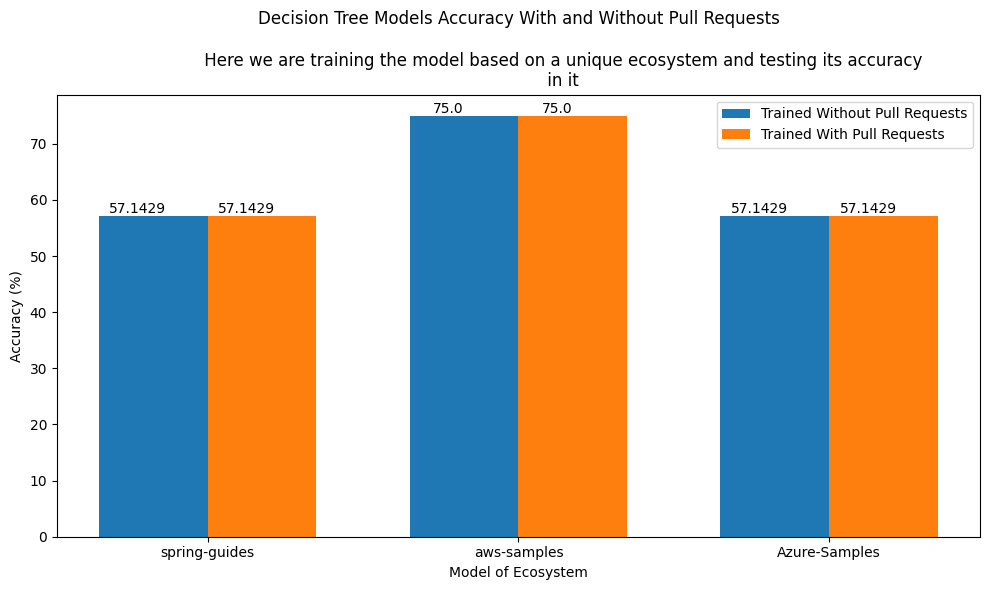

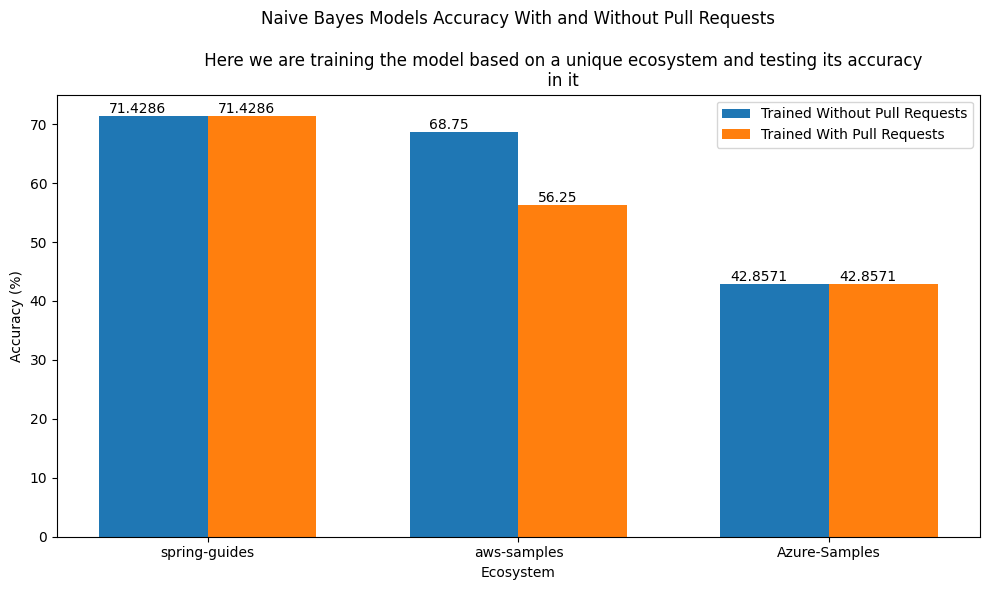

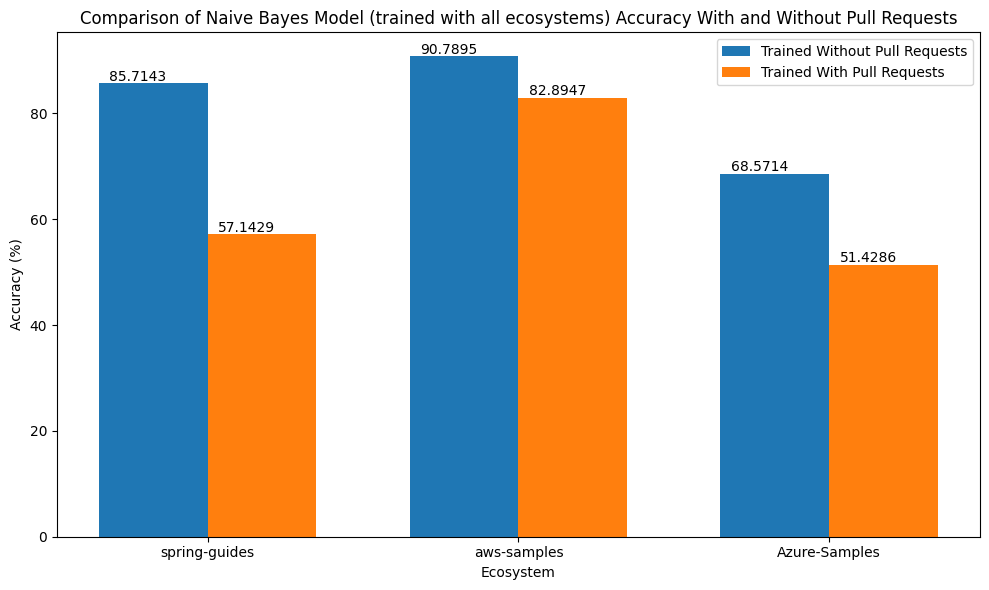

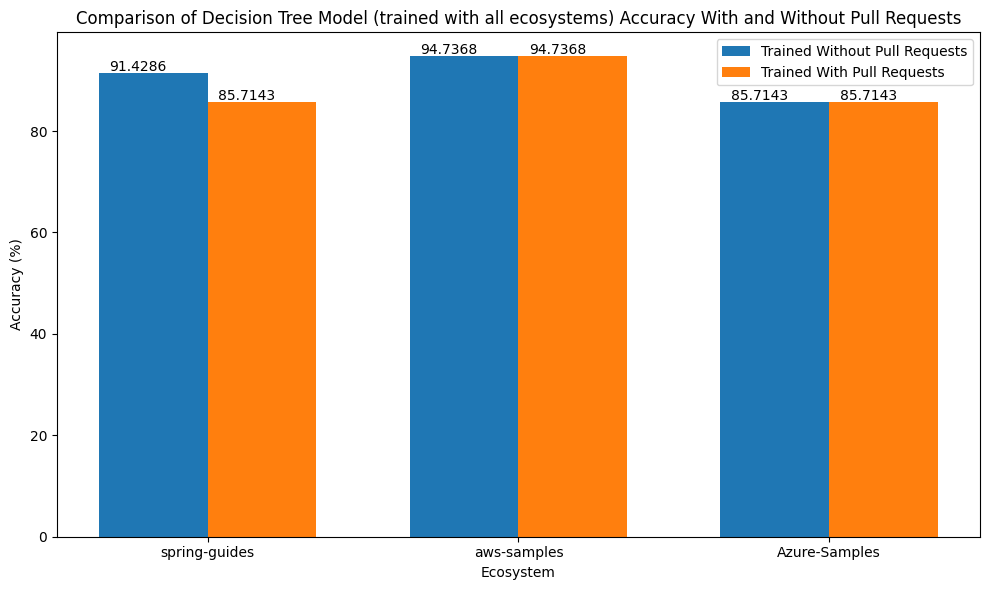

|--- release <= 0.50
|   |--- use <= 0.50
|   |   |--- boot <= 0.50
|   |   |   |--- bump <= 0.50
|   |   |   |   |--- jenkins <= 0.50
|   |   |   |   |   |--- issue <= 0.50
|   |   |   |   |   |   |--- from <= 0.50
|   |   |   |   |   |   |   |--- with <= 0.50
|   |   |   |   |   |   |   |   |--- fixed <= 0.50
|   |   |   |   |   |   |   |   |   |--- files <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- diagram <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- js <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |   |--- readme <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |   |   |--- bugfix <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |   |   |   |--- name <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |--- creating <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |--- drop <= 1.00
|   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |--- additional <= 0.50
|   |   |   |   |   |   |   |   |   |   |

In [64]:
plot_decision_tree_accuracy(repo_infos)
plot_naive_bayes_accuracy(repo_infos)
naive_bayes_accuracy_graph(repo_infos)
decision_tree_accuracy_graph(repo_infos)